# User guide


Greetings!

# The code

In [1]:
# Define the process that the models will be trained for
trainedProcess = "završni"
trainedProcessJSON = "Izrada završnog rada"

JSON setup

In [2]:
json = [
    {
        "name": "Praksa",
        "phases": [
            {
                "name": "Odabir preferencija",
                "alias": ["Prijava prakse", "Odabir zadatka", "Prvi korak"],
                "description": "Odabir preferencija je prvi korak u procesu polaganja prakse. Zahtjeva da student odabere zadatak sa popisa...",
                "duration": "1 mjesec",
            },
            {
                "name": "Ispunjavanje prijavnice",
                "description": "Ispunjavanje prijavnice je drugi korak u procesu polaganja prakse. Student mora ispuniti prijavnicu koja se nalazi na stranici kolegija...",
                "duration": "1 tjedan",
            },
            {
                "name": "Predaja dnevnika prakse",
                "alias": ["Završetak prakse", "Dnevnik"],
                "description": "Predaja dnevnika prakse zadnji je korak u procesu polaganja prakse. S završetkom rada, student predaje dnevnik prakse na stranicu kolegija...",
                "duration": "3 dana",
            },
        ],
        "duration": "2 mjeseca",
    },
    {
        "name": "Izrada završnog rada",
        "phases": [
            {
                "name": "Prijava teme",
                "alias": ["Prvi korak"],
                "description": "Prvi korak u procesu izrade završnog rada je prijava teme. Zahtjeva da student odabere mentora te prijavi temu sa popisa...",
                "duration": "5 dana",
            },
            {
                "name": "Ispuna obrasca",
                "description": "Student ispunjava obrazac sa prijavljenom temom...",
                "duration": "4 dana",
            },
            {
                "name": "Obrana rada",
                "description": "Student brani svoj rad pred komosijom...",
                "duration": "1 sat",
            },
        ],
        "duration": "3 mjeseca",
    },
]

# If tasks do not contain alias propery, assign an empty one to them
for process in json:
    for task in process["phases"]:
        if "alias" not in task:
            task["alias"] = []

## User intent recognition model
Source: https://github.com/AldoF95/intent_recognition_masters_thesis

`!pip install tensorflow_text` requires runtime restart

CPU Training time
- ~~Execution time: ~4m (training included)~~
- ~~Training time: 2m (2 epochs)~~

GPU Training time
- ~~Execution time: ~2m (training included)>~~
- ~~Training time: 40s (2 epochs)~~

Loading spreadsheet might fail if no sheet specified (not sure)


In [3]:
# Define training epochs
training_epochs = 10
label_size = 6

# Define dataset URL for training (old published excel file)
UIDatasetURL_ = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRKZziYPXXp-C3-GWkzAdPaWBRgRidy5OYMwt8RCDEzFLczk4MG8hi3e2Glc7EfEw/pub?output=xlsx'

# Define dataset URL for training (new published excel file)
UIDatasetURL = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSPR-FPTMBcYRynP4JdwYQQ8dAhSx1x8i1LPckUcuIUUlrWT82b5Thqb1bBNnPeGJPxxX1CJAlFSd6F/pub?output=xlsx'

In [4]:
# Will require runetime restart on Google colab (sometimes, idk)
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 15.0 MB/s 
     |████████████████████████████████| 511.8 MB 8.8 kB/s 
     |████████████████████████████████| 5.8 MB 56.6 MB/s 
     |████████████████████████████████| 438 kB 68.0 MB/s 
     |████████████████████████████████| 1.6 MB 50.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [5]:
!pip install text-hr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 5.2 MB/s 


### Data loading

- Define the preprocesor and the base model
- LaBSE 2 base model used: https://tfhub.dev/google/LaBSE/2
- Load the data from published google spreadsheet
- Merge categories and Normalize data within them

In [6]:
import tensorflow as tf
import tensorflow_text as tft
import tensorflow_hub as tfh
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Text preprocessor for bert based models
preprocessor = tfh.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2')

# Language Agnostic BERT sentence encoder
model = tfh.KerasLayer('https://tfhub.dev/google/LaBSE/2')

In [8]:
# Read the data
import pandas as pd
data = pd.read_excel(UIDatasetURL)

In [9]:
columns = ['text', 'intent', 'process']
data.columns = columns

In [10]:
data = data[data["process"] == trainedProcess].drop(columns="process")

In [11]:
data.head()

,text,intent
23,Kako ide prijava završnog rada?,P1
24,Što se sve mora napraviti za završni rad?,P1
25,Procesi završnog rada,P1
26,Kako se prijavljuje tema za završni rad?,P3
27,Kako ide obrana završnog rada?,P3


#### Category merging

In [12]:
# Convert categories to codes
data['intent'] = data['intent'].astype('category')
data['intent_codes'] = data['intent'].cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


<StemContainer object of 3 artists>

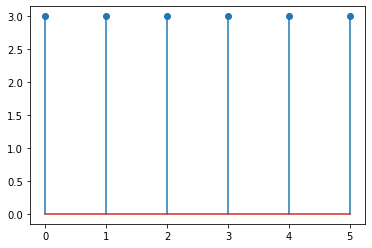

In [13]:
# Display the distribution of codes
values = data['intent'].value_counts()
plt.stem(values)

#### Normalize data

In [14]:
"""
upis_data = data[data['intent02'] == 'upis_na_sveuciliste']
upis_data = upis_data.sample(frac=1, random_state=1234)
upis_data = upis_data.sample(40)
upis_data.info()
"""

"\nupis_data = data[data['intent02'] == 'upis_na_sveuciliste']\nupis_data = upis_data.sample(frac=1, random_state=1234)\nupis_data = upis_data.sample(40)\nupis_data.info()\n"

In [15]:
"""
ood_data = data[data['intent02'] == 'OOD']
ood_data = ood_data.sample(frac=1, random_state=1234)
ood_data = ood_data.sample(40)
ood_data.info()
"""

"\nood_data = data[data['intent02'] == 'OOD']\nood_data = ood_data.sample(frac=1, random_state=1234)\nood_data = ood_data.sample(40)\nood_data.info()\n"

In [16]:
"""
data2 = data[(data['intent02'] != 'OOD') & (data['intent02'] != 'upis_na_sveuciliste')]
data2.info()
"""

"\ndata2 = data[(data['intent02'] != 'OOD') & (data['intent02'] != 'upis_na_sveuciliste')]\ndata2.info()\n"

In [17]:
"""
data2 = data2.append(upis_data, ignore_index=True)
data2 = data2.append(ood_data, ignore_index=True)
"""

'\ndata2 = data2.append(upis_data, ignore_index=True)\ndata2 = data2.append(ood_data, ignore_index=True)\n'

In [18]:
"""
values = data2['intent02'].value_counts()
plt.stem(values)
"""

"\nvalues = data2['intent02'].value_counts()\nplt.stem(values)\n"

In [19]:
# data = data2

### Text preprocessing

1. Remove punctuation
2. Lowercase the text
3. Apply tokenization
4. Remove stopwords
5. Apply lemmatizer

In [20]:
import string
import re
import nltk
import text_hr

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [21]:
def remove_punctuation(text):
    return "".join([i for i in text if i not in string.punctuation])

def tokenization(text):
    return re.split(r"\s+",text)

stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    return [i for i in text if i not in stopwords]

porter_stemmer = PorterStemmer()
def stemming(text):
    return [porter_stemmer.stem(word) for word in text]

wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    return [wordnet_lemmatizer.lemmatize(word) for word in text]

In [22]:
data['text'] = data['text']\
    .apply(lambda x: remove_punctuation(x))\
    .apply(lambda x: x.lower())\
    .apply(lambda x: tokenization(x))\
    .apply(lambda x: lemmatizer(x))

In [23]:
data['text'].head()

23                 [kako, ide, prijava, završnog, rada]
24    [što, se, sve, mora, napraviti, za, završni, rad]
25                            [procesi, završnog, rada]
26      [kako, se, prijavljuje, tema, za, završni, rad]
27                  [kako, ide, obrana, završnog, rada]
Name: text, dtype: object

In [24]:
stop_words_list_hr = []
for word_base, l_key, cnt, _suff_id, wform_key, wform in text_hr.get_all_std_words():
    if word_base is not None: stop_words_list_hr.append(word_base)
    if wform is not None: stop_words_list_hr.append(wform)

In [25]:
stop_words_list_hr = list(dict.fromkeys(stop_words_list_hr))
len(stop_words_list_hr)

1207

In [26]:
def remove_stopwords_hr(text):
    output = [i for i in text if i not in stop_words_list_hr]
    return output

In [27]:
data['text'] = data['text'].apply(lambda x: remove_stopwords_hr(x))

In [28]:
data['text'].head()

23       [ide, prijava, završnog, rada]
24            [napraviti, završni, rad]
25            [procesi, završnog, rada]
26    [prijavljuje, tema, završni, rad]
27        [ide, obrana, završnog, rada]
Name: text, dtype: object

In [29]:
data['text'] = data['text'].str.join(" ")
data['text'].head()

23       ide prijava završnog rada
24           napraviti završni rad
25           procesi završnog rada
26    prijavljuje tema završni rad
27        ide obrana završnog rada
Name: text, dtype: object

In [30]:
data.head()

,text,intent,intent_codes
23,ide prijava završnog rada,P1,0
24,napraviti završni rad,P1,0
25,procesi završnog rada,P1,0
26,prijavljuje tema završni rad,P3,2
27,ide obrana završnog rada,P3,2


### Split validation and training data

Train 75%, validation 25%

In [31]:
codes = data['intent_codes'].unique()

In [32]:
# Variable to understand the meaning behind codes
CODES_REPR = data[["intent_codes", "intent"]].drop_duplicates().sort_values("intent_codes")


def codeToIntent(prediction) -> str:
    """ Returns the intent of the prediction, not the code """
    return CODES_REPR[CODES_REPR["intent_codes"] == prediction.argmax()].iloc[0]["intent"]

In [33]:
preprocessed_validation_data = pd.DataFrame(columns=data.columns)
preprocessed_train_data = pd.DataFrame(columns=data.columns)

for c in codes:
    sample = data[data['intent_codes'] == c]
    sample = sample.sample(frac=1)
    # val = sample.sample(frac=0.25)
    val = sample.sample(frac=0)
    train = pd.concat([sample, val]).drop_duplicates(keep=False)
    preprocessed_validation_data = preprocessed_validation_data.append(val, ignore_index=True)
    preprocessed_train_data = preprocessed_train_data.append(train, ignore_index=True)

In [34]:
# Preprocessed google translation data
train_data_eng = preprocessed_train_data[['text', 'intent_codes']]
train_data_eng.columns = ['text', 'intent_codes']

validation_data_eng = preprocessed_validation_data[['text', 'intent_codes']]
validation_data_eng.columns = ['text', 'intent_codes']

In [35]:
def df_to_dataset(df, shuffle=True, batch_size=16):
    df = df.copy()
    labels = df.pop('intent_codes')
    lables_cat = tf.keras.utils.to_categorical(labels, label_size)
    dataset = tf.data.Dataset.from_tensor_slices((dict(df), lables_cat))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size).prefetch(batch_size)
    return dataset

In [36]:
_validation = train_data_eng
train_data_eng = df_to_dataset(train_data_eng)

# validation_data_eng = df_to_dataset(validation_data_eng)
validation_data_eng = df_to_dataset(_validation)

### Model definition and training

2 epochs training (testing purposes)

In [37]:
# Model builder
def model_build():
    inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoded_input = preprocessor(inputs)
    encoder_outputs = model(encoded_input)

    x = encoder_outputs['pooled_output']
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    outputs = tf.keras.layers.Dense(label_size, activation='softmax', name='classifier')(x)
    
    return tf.keras.Model(inputs, outputs)

# Build a model with preprocessed data 
model_eng = model_build()
model_eng.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = tf.keras.metrics.CategoricalAccuracy()
)

eng_history = model_eng.fit(
    train_data_eng,
    epochs = training_epochs,
    batch_size = 16,
    validation_data = validation_data_eng
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


2/2 [==============================] - 11s 1s/step - loss: 2.1450 - categorical_accuracy: 0.0556 - val_loss: 1.6249 - val_categorical_accuracy: 0.1667
Epoch 2/10
2/2 [==============================] - 0s 208ms/step - loss: 2.0185 - categorical_accuracy: 0.1667 - val_loss: 1.4103 - val_categorical_accuracy: 0.3889
Epoch 3/10
2/2 [==============================] - 0s 199ms/step - loss: 1.5960 - categorical_accuracy: 0.3889 - val_loss: 1.2507 - val_categorical_accuracy: 0.7222
Epoch 4/10
2/2 [==============================] - 0s 201ms/step - loss: 1.5395 - categorical_accuracy: 0.3889 - val_loss: 1.1226 - val_categorical_accuracy: 0.8333
Epoch 5/10
2/2 [==============================] - 0s 202ms/step - loss: 1.6944 - categorical_accuracy: 0.2778 - val_loss: 1.0165 - val_categorical_accuracy: 0.8889
Epoch 6/10
2/2 [==============================] - 0s 200ms/step - loss: 1.5644 - categorical_accuracy: 0.3889 - val_loss: 0.9337 - val_categorical_accuracy: 1.0000
Epoch 7/10
2/2 [=============

## Finetuned NER model
Source: https://github.com/dmoonat/Named-Entity-Recognition/blob/main/Fine_tune_NER.ipynb <br>

CPU Training time
- Execution time: ~25 min (training included)
- Training time: ~20 min (2 epochs, 1k data)
- Finetuning time: ~1 min (10 epochs, 3 data)

In [38]:
# Define training epochs
mainEpochs = 2

# Define finetuning epochs
finetuneEpochs = 10

In [39]:
!pip install datasets -q
!pip install tokenizers -q
!pip install transformers -q
!pip install seqeval -q

     |████████████████████████████████| 365 kB 14.9 MB/s 
     |████████████████████████████████| 212 kB 71.8 MB/s 
     |████████████████████████████████| 120 kB 67.5 MB/s 
     |████████████████████████████████| 115 kB 65.4 MB/s 
     |████████████████████████████████| 127 kB 72.7 MB/s 
     |████████████████████████████████| 6.6 MB 15.6 MB/s 
     |████████████████████████████████| 4.7 MB 15.4 MB/s 
     |████████████████████████████████| 43 kB 61 kB/s 


### Load the datasets

Loading [Wikianng](https://huggingface.co/datasets/wikiann) main croatian dataset

Loading custom [Google spreadsheeta](https://docs.google.com/spreadsheets/d/e/2PACX-1vSPR-FPTMBcYRynP4JdwYQQ8dAhSx1x8i1LPckUcuIUUlrWT82b5Thqb1bBNnPeGJPxxX1CJAlFSd6F/pub?output=xlsx) finetuning croatian dataset

In [40]:
from datasets import load_dataset, Dataset
import pandas as pd

# Main training data
dataset = load_dataset("wikiann", "hr")

# Define dataset URL for training (new published excel file)
UIDatasetURL = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSPR-FPTMBcYRynP4JdwYQQ8dAhSx1x8i1LPckUcuIUUlrWT82b5Thqb1bBNnPeGJPxxX1CJAlFSd6F/pub?output=xlsx'

# Finetuning data
nerData = pd.read_excel(UIDatasetURL, sheet_name="List 2")

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/hr/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [41]:
nerTags = [[int(nerTag) for nerTag in i.split(' ')] for i in nerData['ner_tags'].values.tolist()]
langs = [['hr'] * len(i) for i in nerTags]
tokens = [tokens.split(' ') for tokens in nerData['tokens'].values.tolist()]
spans = [[spans] for spans in nerData['spans'].values.tolist()]

# Convert data to Dataset
fineTunedDs = Dataset.from_dict({
    'langs': langs,
    'ner_tags': nerTags,
    'spans': spans,
    'tokens': tokens
})

In [42]:
# label_names = dataset["train"].features["ner_tags"].feature.names
label_names = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [43]:
nerData = nerData[nerData["process"] == trainedProcess].drop(columns="process")

In [44]:
nerData

,ner_tags,tokens,spans
8,0 0 3 4,Koliko traje prijava teme?,ORG: Prijava teme
9,0 0 3 4 0 0,Kako da ispunim obrazac za završni?,ORG: Ispunjavanje obrasca
10,0 0 3 4 0 0 0,Koji je prvi korak kod izrade završnog?,ORG: Prvi korak
11,0 0 3 0 4,Kada je obrana završnog rada,ORG: Obrana rada


### Data preprocessing (tokenization)

Using [xlm-roberta-base](https://huggingface.co/xlm-roberta-base) tokenizer

In [45]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

In [46]:
# Get the values for input_ids, attention_mask, adjusted labels
def tokenize_adjust_labels(all_samples_per_split):
    tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True, truncation=True)

    total_adjusted_labels = []
  
    for k in range(0, len(tokenized_samples["input_ids"])):
        prev_wid = -1
        word_ids_list = tokenized_samples.word_ids(batch_index=k)
        existing_label_ids = all_samples_per_split["ner_tags"][k]
        i = -1
        adjusted_label_ids = []
   
        for word_idx in word_ids_list:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                adjusted_label_ids.append(-100)
            elif word_idx != prev_wid:
                i += 1
                adjusted_label_ids.append(existing_label_ids[i])
                prev_wid = word_idx
            else:
                label_name = label_names[existing_label_ids[i]]
                adjusted_label_ids.append(existing_label_ids[i])
                
        total_adjusted_labels.append(adjusted_label_ids)
    
    # Add adjusted labels to the tokenized samples
    tokenized_samples["labels"] = total_adjusted_labels
    return tokenized_samples

# Apply tokenization to both main and finetuning datasets  
tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True, remove_columns=['tokens', 'ner_tags', 'langs', 'spans'])
tokenizedFineTunedDs = fineTunedDs.map(tokenize_adjust_labels, batched=True, remove_columns=['tokens', 'ner_tags', 'langs', 'spans'])

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

### Preparations

Using [xlm-roberta-base](https://huggingface.co/xlm-roberta-base) model

In [47]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification, AdamW

In [48]:
# Check if gpu is present
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [49]:
model = AutoModelForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=len(label_names))
model.to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-st

XLMRobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Layer

In [50]:
import numpy as np
from datasets import load_metric
metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p

    # Select predicted index with maximum logit for each token
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

### Model training and finetuning

```
batch_size = 16
mainEpochs = 2  # previously defined
finetuneEpochs = 10  # previously defined
```

In [51]:
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification

batch_size = 16
# logging_steps = len(tokenized_dataset['train']) // batch_size
# logging_steps = len(Dataset.from_dict(tokenized_dataset["validation"][:1000])) // batch_size
# logging_steps = len(tokenizedFineTunedDs) // batch_size


training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert-fine-tune-ner/results",
    # num_train_epochs=epochs,
    num_train_epochs=mainEpochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    # logging_steps=logging_steps,
)

In [52]:
trainer = Trainer(
    model=model,
    args=training_args,

    # Select only the first 1000 examples
    train_dataset=Dataset.from_dict(tokenized_dataset["train"][:1000]),
    eval_dataset=Dataset.from_dict(tokenized_dataset["validation"][:1000]),
    
    # train_dataset=tokenized_dataset["train"],
    # eval_dataset=tokenized_dataset["validation"],
    
    data_collator=DataCollatorForTokenClassification(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [53]:
# Fine tune using train method
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 126


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.470491,0.541750,0.653477,0.592391,0.860311
2,No log,0.379691,0.666191,0.746603,0.704109,0.893577


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=126, training_loss=0.6169798714773995, metrics={'train_runtime': 32.2876, 'train_samples_per_second': 61.943, 'train_steps_per_second': 3.902, 'total_flos': 38747161184160.0, 'train_loss': 0.6169798714773995, 'epoch': 2.0})

In [54]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert-fine-tune-ner/results",
    num_train_epochs=finetuneEpochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    # logging_steps=logging_steps,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [55]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenizedFineTunedDs,
    eval_dataset=tokenizedFineTunedDs,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [56]:
trainer.train()

***** Running training *****
  Num examples = 12
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.493576,0.142857,0.100000,0.117647,0.528090
2,No log,0.915248,0.250000,0.150000,0.187500,0.662921
3,No log,0.894435,0.666667,0.400000,0.500000,0.707865
4,No log,0.821148,0.615385,0.400000,0.484848,0.707865
5,No log,0.707011,0.470588,0.400000,0.432432,0.752809
6,No log,0.592415,0.571429,0.400000,0.470588,0.775281
7,No log,0.504502,0.571429,0.400000,0.470588,0.797753
8,No log,0.444581,0.588235,0.500000,0.540541,0.865169
9,No log,0.408729,0.588235,0.500000,0.540541,0.865169
10,No log,0.394338,0.611111,0.550000,0.578947,0.865169


***** Running Evaluation *****
  Num examples = 12
  Batch size = 16
***** Running Evaluation *****
  Num examples = 12
  Batch size = 16
***** Running Evaluation *****
  Num examples = 12
  Batch size = 16
***** Running Evaluation *****
  Num examples = 12
  Batch size = 16
***** Running Evaluation *****
  Num examples = 12
  Batch size = 16
***** Running Evaluation *****
  Num examples = 12
  Batch size = 16
***** Running Evaluation *****
  Num examples = 12
  Batch size = 16
***** Running Evaluation *****
  Num examples = 12
  Batch size = 16
***** Running Evaluation *****
  Num examples = 12
  Batch size = 16
***** Running Evaluation *****
  Num examples = 12
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=10, training_loss=0.9774024963378907, metrics={'train_runtime': 2.0989, 'train_samples_per_second': 57.173, 'train_steps_per_second': 4.764, 'total_flos': 796174544880.0, 'train_loss': 0.9774024963378907, 'epoch': 10.0})

In [57]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 12
  Batch size = 16


{'eval_loss': 0.39433833956718445,
 'eval_precision': 0.6111111111111112,
 'eval_recall': 0.55,
 'eval_f1': 0.5789473684210527,
 'eval_accuracy': 0.8651685393258427,
 'eval_runtime': 0.056,
 'eval_samples_per_second': 214.462,
 'eval_steps_per_second': 17.872,
 'epoch': 10.0}

In [58]:
"""
predictions, labels, _ = trainer.predict(tokenizedFineTunedDs)
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
results = metric.compute(predictions=true_predictions, references=true_labels)
results
"""

'\npredictions, labels, _ = trainer.predict(tokenizedFineTunedDs)\npredictions = np.argmax(predictions, axis=2)\n\n# Remove ignored index (special tokens)\ntrue_predictions = [\n    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]\n    for prediction, label in zip(predictions, labels)\n]\ntrue_labels = [\n    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]\n    for prediction, label in zip(predictions, labels)\n]\nresults = metric.compute(predictions=true_predictions, references=true_labels)\nresults\n'

## Using the NER model

- More diverse fine tuning examples needed

In [59]:
!pip install datasets -q

In [60]:
import numpy as np
from datasets import Dataset
from typing import List, Dict

In [61]:
def datasetBuilder(text: str) -> Dataset:
    """ Returns instance of Dataset object ready for prediction """
    return Dataset.from_dict({ 'tokens': [text] })

In [62]:
# Get the values for input_ids, attention_mask
def tokenizer_encode(ds: Dataset):
    return tokenizer.batch_encode_plus([ds["tokens"][0]], is_split_into_words=False, truncation=True)

In [63]:
def getPrediction(tokenizedDs: Dataset) -> List[List[int]]:
    """ Returns a list of a list of NER codes """
    predictions, labels, _ = trainer.predict(tokenizedDs)
    return np.argmax(predictions, axis=2)

In [64]:
# Old function
# Function that shows the result
def outcome_(ner_pred: List[str], initialText: str) -> Dict:
    modelLabels = ["PER", "ORG", "LOC"]

    nerDict = {i: [] for i in modelLabels}
    nerDict[""] = []

    currentStringList = []
    currentEntity = ""
    tokenizedText = tokenizer.tokenize(initialText)

    for i, x in enumerate(tokenizedText):
        if ner_pred[i] == 0:
            continue
        elif ner_pred[i] % 2 == 0:
            currentStringList.append(x)
        else:
            nerDict[currentEntity].append(" ".join(currentStringList))
            currentStringList = [x]
            currentEntity = modelLabels[(ner_pred[i] - 1) // 2]

    nerDict[currentEntity].append(" ".join(currentStringList))
    del nerDict[""]

    # Return dictionary without empty values
    return {k: v for k, v in nerDict.items() if v}


# Function that shows the result
def outcome(ner_pred: List[str], initialText: str) -> Dict:
    tokenizedText = tokenizer.tokenize(initialText)
    currentString = "".join([x for i, x in enumerate(tokenizedText) if ner_pred[i] != 0])
                
    # Return dictionary without empty values
    return { "Task": currentString.replace("▁", " ")[1:] }

In [65]:
def predictNER(text: str, debugging: bool=True) -> Dict:
    # Input goes here
    testDs = datasetBuilder(text)

    # Tokenize input
    tokenizedTestDs = testDs.map(tokenizer_encode, batched=True, remove_columns=['tokens'])

    # Get predictions
    true_predictions = getPrediction(tokenizedTestDs)

    if debugging: print(true_predictions)

    # Return all NERs
    return outcome(true_predictions[0][1:-1], text)

In [66]:
print(predictNER("Kako se istaknuo Marko"))
print(predictNER("U Telekomu nije bilo svijetla"))
print(predictNER("Zašto je išao u Plodine"))
print()
print(predictNER("Imam pitanje u vezi odabira preferencija"))
print(predictNER("Šta sve moram napraviti za ispunjavanje prijavnice"))
print(predictNER("Kada se predaje dnevnik prakse?"))
print()
print(predictNER("Šta da napravim ako trebam prijaviti dnevnik prakse?"))
print(predictNER("Kako ide prijavljivanje dnevnika prakse?"))
print(predictNER("Gdje da odaberem preferencije?"))
print(predictNER("Gdje da ispunim prijavnicu?"))
print(predictNER("Pomoc, ne znam kako predati dnevnik"))



  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[0 0 0 0 1 0]]
{'Task': 'Marko'}


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[0 0 3 3 0 0 0 0 0]]
{'Task': 'Telekomu'}


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[0 0 0 0 0 0 5 5 0]]
{'Task': 'Plodine'}



  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[4 0 0 0 0 3 3 4 4 4 0]]
{'Task': 'odabira preferencija'}


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[4 0 0 0 0 0 3 0 4 4 0]]
{'Task': 'ispunjava prijavnice'}


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[4 0 0 0 0 4 4 0 0]]
{'Task': 'dnevnik prakse'}



  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[0 0 0 0 0 0 0 0 0 3 4 0 0]]
{'Task': 'dnevnik prakse'}


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[4 0 0 3 3 4 4 4 0 4]]
{'Task': 'prijavljivanje dnevnika prakse'}


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[4 0 0 0 3 0 3 4 4 0 4]]
{'Task': 'ber preferencije'}


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[4 0 0 0 0 4 4 0 4]]
{'Task': 'prijavnicu'}


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[4 0 0 0 0 0 0 0 3 0]]
{'Task': 'dnevnik'}


In [67]:
predictNER("Gdje se izvršava obrana rada?")

  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[4 0 0 0 0 3 3 4 0 0]]


{'Task': 'obrana rada'}

## Testing the NER model

In [68]:
testCases = [
    predictNER("Pomoc, ne znam kako predati dnevnik") == {'Task': 'predati dnevnik'},
    predictNER("Gdje da ispunim prijavnicu?") == {'Task': 'ispuni prijavnicu?'},
    predictNER("Gdje da odaberem preferencije?") == {'Task': 'odaberem preferencije'},
    predictNER("Kako ide prijavljivanje dnevnika prakse?") == {'Task': 'prijavljivanje dnevnika prakse'},
    predictNER("Šta da napravim ako trebam prijaviti dnevnik prakse?") == {'Task': 'prijaviti dnevnik prakse'}
]

all(testCases)

  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[4 0 0 0 0 0 0 0 3 0]]


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[4 0 0 0 0 4 4 0 4]]


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[4 0 0 0 3 0 3 4 4 0 4]]


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[4 0 0 3 3 4 4 4 0 4]]


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 1
  Batch size = 16


[[0 0 0 0 0 0 0 0 0 3 4 0 0]]


False

## Testing the user intent model

In [69]:
from typing import List

In [70]:
# Praksa
# P1: Što sve moram za prasku
# P2: Koliko traje praksa?
# P3: Kako treba {task}?
# P4: Koliko traje {task}?
# P5: Što je nakon {task}?
# P6: Šta ako ne mogu doći na praksu?

# Završni
# P1: Kako ide proces izrade završnog rada?
# P2: Kako se {task}?
# P3: Koliko traje {task}?
# P4: Što je nakon {task}?
# P5: Šta ako je vani kiša?

"""
examples = [
    { "text": "Trebam odradit praksu", "intent": "P1"},
    { "text": "Koliko traje praksa?", "intent": "P2"},
    { "text": "Kako ide odabir preferencija", "intent": "P3"},
    { "text": "Koliko traje odabir preferencija?", "intent": "P4"},
    { "text": "Šta ide nakon predaja dnevnika prakse?", "intent": "P5"},
    { "text": "Šta ako ne mogu doći na praksu?", "intent": "P6"},
]
"""

examples = [
    { "text": "Kako ide proces izrade završnog rada?", "intent": "P1"},
    { "text": "Kako se prijavljuje tema za završni rad?", "intent": "P2"},
    { "text": "Koliko traje prijava teme", "intent": "P3"},
    { "text": "Šta je nakon obrane rada?", "intent": "P4"},
    { "text": "Šta ako je vani kiša?", "intent": "P5"},
]

def testIntentModel(intentModel) -> List[bool]:
    """ Test the abovetrained model on some "must work" examples """
    text_examples = [e["text"] for e in examples]
    y_pred = intentModel.predict(text_examples, verbose=False)
    return [codeToIntent(y) == examples[i]["intent"] for i, y in enumerate(y_pred)]

# Aim to have as many Trues as possible
testResults = testIntentModel(model_eng)

print(f"Results: {testResults}")
print(f"All test passed: {all(testResults)}")

Results: [True, False, False, False, False]
All test passed: False


## Sentence similarity

In [71]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.0 MB/s 
     |████████████████████████████████| 1.3 MB 62.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=5925053c24968ece38bd0d1707f409cc044e0d2d017f729f98e45e50603d34b8
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [72]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

loading configuration file /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/config.json
Model config BertConfig {
  "_name_or_path": "/root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /root/.cache/torch/sentence_transformers/sentence-transformers_all-MiniLM-L6-v2/pytorch_model.bin
All model checkpoint weights were used when i

In [73]:
from typing import List

In [74]:
def getTaskSimilarityIndex(flatIndex: int, tasks) -> int:
    """ Get task index based on the flatten task list """
    for index, task in enumerate(tasks):
        if flatIndex <= len(task["alias"]):
            return index
        
        flatIndex -= len(task["alias"]) + 1
        
    return -1

In [75]:
def getFlattenTasks(tasks) -> List[str]:
    """ Returns the flatten version of task names and their aliases """
    resTasks = []

    for task in tasks:
        resTasks.append(task["name"])
        resTasks = resTasks + task["alias"]
    
    return resTasks

In [76]:
def taskSimilarity(text: str, tasks) -> int:
    """ Returns the task index which is the most similar to the text """
    return getTaskSimilarityIndex(torch.argmax(util.pytorch_cos_sim(
        model.encode(text, convert_to_tensor=True),
        model.encode(getFlattenTasks(tasks), convert_to_tensor=True)
    )).item(), tasks)

In [77]:
sentence = "Što je prvo što moram za završni?"

print(taskSimilarity(sentence, json[1]["phases"]))

0


## Using the user intent model

Work in progress <br />

TO DO:
- Excel: proces šifrirati nekom brojkom, i poboljšati indexiranje ("Process" vs "process")
- Napraviti test za user intent (zavrsni)


TO DO 2:
- Improve the model accuracy (add more user intent cases)
- Train / validation data split (on bigger dataset)
- User intent for process (will make the arhitecture of this code as follows: Process intent -> Question intent -> NER extraction technique)

In [78]:
def preprocessText(text: str) -> str:
    """ Do the same preprocessing as the UI model training input data """
    text = remove_punctuation(text)
    text = text.lower()
    text = tokenization(text)
    text = lemmatizer(text)
    text = remove_stopwords_hr(text)

    return " ".join(text)

In [79]:
def predict_intent(text: str) -> str:
    """ Predict the text intent based on the abovetrained model """
    return codeToIntent(model_eng.predict([preprocessText(text)], verbose=False))

In [80]:
def getPhases(phases) -> str:
    """ P1: Returns the formatted phases """
    phases = [phase["name"].lower() for phase in phases]
    return ', '.join(phases[:-1]) + ' i ' + phases[-1]

In [81]:
# Define functions that handle output text formatting

def getP1String(process) -> str:
    return f"Faze procesa za proces '{process['name']}' su: {getPhases(process['phases'])}"

def getP2String(process) -> str:
    return f"Proces '{process['name']}' traje {process['duration']}"

def getP3String(taskName: str, task) -> str:
    return f"Kratki opis '{taskName}': {task['description']}"

def getP4String(taskName: str, task) -> str:
    return f"Proces '{taskName}' traje {task['duration']}"

def getP5String(taskIndex: int, taskName: str, process) -> str:
    if len(process["phases"]) <= taskIndex + 1:
        return f"'{taskName}' je zadnji korak u procesu '{process['name']}'"
    
    return f"Nakon '{taskName}' je '{process['phases'][taskIndex + 1]['name'].lower()}'"

def getP6String() -> str:
    return "Nažalost, ne razumijem Vaše pitanje"

In [82]:
def print_result(text: str, process) -> None:
    """ Chatbot output messages based on intent """
    intent = predict_intent(text)
    taskIndex = taskSimilarity(text, process["phases"])
    task = process["phases"][taskIndex]
    taskName = task["name"].lower()

    # P1: Koje su faze
    if intent == 'P1':
        print(getP1String(process))

    # P2: Koliko traje cijeli proces
    elif intent == 'P2':
        print(getP2String(process))

    # P3: Kako ide odabir preferencija?
    elif intent == 'P3':
        print(getP3String(taskName, task))

    # P4: Koliko traje {task}
    elif intent == 'P4':
        print(getP4String(taskName, task))

    # P5: Što je nakon {task}
    elif intent == 'P5':
        print(getP5String(taskIndex, taskName, process))
    
    # Ništa od navedenog
    else:
        print(getP6String())

In [83]:
def chatbot(processName: str) -> None:
    """ By: Rafael Krstačić """
    currentProcess = None

    for process in json:
        if process["name"] == processName:
            currentProcess = process
            break
    else:
        raise KeyError("Process does not exist in json")

    print("Za prekid razgovora unesi 'q'")
    while True:
        user_input = input("\n>>> ")
        if user_input.lower() == "q":
            break

        print_result(user_input, currentProcess)
    print("Doviđenja! ( ^_^)/")


In [84]:
# Examples that work as of 02/08/2022 21:00
# P1: Napraviti praksu
# P2: Kojim redosljedom idu faze prakse?
# P3: Koliko traje praksa?
# P4: Šta je sastanak?
chatbot(trainedProcessJSON)

Za prekid razgovora unesi 'q'

>>> Koliko traje završni?
Proces 'Izrada završnog rada' traje 3 mjeseca

>>> Šta sve ima završni?
Faze procesa za proces 'Izrada završnog rada' su: prijava teme, ispuna obrasca i obrana rada

>>> Koliko traje prijava teme?
Proces 'prijava teme' traje 5 dana

>>> Šta moram napravit za prijavu teme?
Nakon 'prijava teme' je 'ispuna obrasca'

>>> Što sve moram za prijavu teme?
Nakon 'prijava teme' je 'ispuna obrasca'

>>> Opis prijave teme?
Kratki opis 'prijava teme': Prvi korak u procesu izrade završnog rada je prijava teme. Zahtjeva da student odabere mentora te prijavi temu sa popisa...

>>> Koliko traje večera?
Proces 'Izrada završnog rada' traje 3 mjeseca

>>> q
Doviđenja! ( ^_^)/


In [85]:
# Demo queries


# kolko traje praska?
# sta ide nakon predaja dnevnika?
# sto je nakon prijavnic=
# Trebam riješiti praksu
# Kako ide oabir preferencaij?
# trajanje odabira preferenca
# U 5 mi je bus, dal cu stic?
# q